In [1]:
import lpips
import pickle
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision.transforms.functional import to_pil_image as tensor2pil

from utils import resize_tensor
from runners import SingleGPUTrainerRunner_v5 as TrainerRunner_v2

In [2]:
from config.classification.cifar10_adversary_sigma_25.data_config import data_config
from config.classification.cifar10_adversary_sigma_25.classifier_config import classifier_config
from config.classification.cifar10_adversary_sigma_25.data_config import data_config
from config.classification.cifar10_adversary_sigma_25.diffusion_config import diffusion_config
from config.classification.cifar10_adversary_sigma_25.train_config import train_config
from config.classification.cifar10_adversary_sigma_25.unet_config import unet_config

# shutil.copytree("./config/classification/cifar10_sigma_100", os.path.join(train_config.log.path, "configs"))

cifar_runner = TrainerRunner_v2(
    data_config = data_config,
    diffusion_config = diffusion_config,
    unet_config = unet_config,
    classifier_config = classifier_config,
    train_config = train_config,
    device = train_config.device
)

# cifar_runner.train()

Files already downloaded and verified
Files already downloaded and verified
sigma: 0.25	T: 598


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

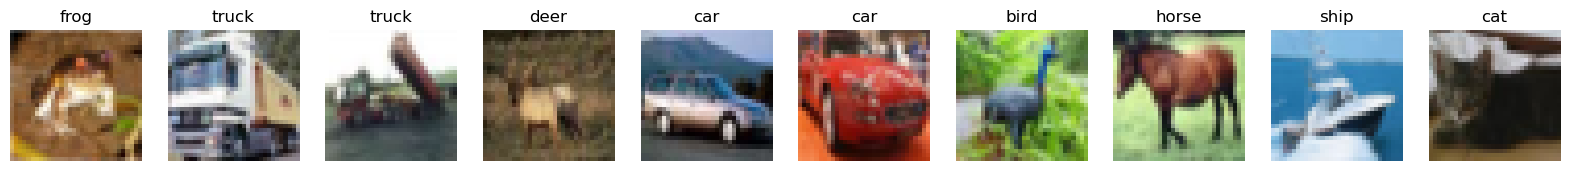

In [4]:
image_indecies = [ix for ix in range(10)]

fig, axs = plt.subplots(1, len(image_indecies))
fig.set_size_inches(2 * len(image_indecies),2)

for ix in image_indecies:
    X, Y = cifar_runner.train_dataset.__getitem__(ix)

    ax = axs[ix]
    
    ax.imshow(
        tensor2pil(
            X
        )
    )
    ax.set_yticks([])
    ax.set_xticks([])

    ax.spines[:].set_visible(False)

    ax.set_title(classes[Y])

In [5]:
def find_t(sigma):
    std_diffusion = cifar_runner.diffusion.sqrt_one_minus_alphas_cumprod / cifar_runner.diffusion.sqrt_alphas_cumprod
    T = np.argmin( 
        np.abs(sigma - std_diffusion)
    )
    T = torch.tensor([T])
    return T + 1

In [11]:
def l2_distance(X1, X2):
    return torch.pow((X1 - X2), 2).sum(dim=[1,2,3]).sqrt()

# sigmas = torch.arange(0,1.1,0.1)
sigmas = [ix/20 for ix in range(21)]
num_samples_per_sigma = 3000
batch_size = 100
device = cifar_runner.train_config.device

subset_indecies = torch.randperm(len(cifar_runner.train_dataset))[:num_samples_per_sigma]
subset_dataset = Subset(cifar_runner.train_dataset, subset_indecies)

# Create a DataLoader for the subset
subset_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=False)

loss_fn_vgg = lpips.LPIPS(net='vgg').to(device)

lpips_distances_denoised = {sigma: [] for sigma in sigmas}
lpips_distances_not_denoised = {sigma: [] for sigma in sigmas}

l2_distances_denoised = {sigma: [] for sigma in sigmas}
l2_distances_not_denoised = {sigma: [] for sigma in sigmas}

for (X, _) in tqdm(subset_loader):
    X = X.to(device)
    for sigma in sigmas:
        noise = torch.randn_like(X)
        t = find_t(sigma)
        t = t.repeat(batch_size).to(device)
        
        X_0_t = cifar_runner.get_x_0_t(
            X,
            t, 
            noise = noise
        )

        lpips_distances_denoised[sigma] += loss_fn_vgg(X, X_0_t)[:, 0, 0, 0].tolist()
        lpips_distances_not_denoised[sigma] += loss_fn_vgg(X, X + sigma * noise)[:, 0, 0, 0].tolist()

        l2_distances_denoised[sigma] += l2_distance(X, X_0_t).tolist()
        l2_distances_not_denoised[sigma] += l2_distance(X, X + sigma * noise).tolist()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/ahedayat/anaconda3/envs/ds_classifier_training/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahedayat/anaconda3/envs/ds_classifier_training/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/ahedayat/anaconda3/envs/ds_classifier_training/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


  0%|                                                                                                                                                            | 0/30 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [2]:
def save_pickle(saving_path, data):
    with open(saving_path, "wb") as file:
        # print("hello")
        pickle.dump(data, file)

def load_pickle(loading_path):
    loaded_object = None
    with open(loading_path, "rb") as file:
        loaded_object = pickle.load(file)
    return loaded_object

In [3]:
# save_pickle("./ICML_plots/lpips_distances_denoised.pickle", lpips_distances_denoised)
# save_pickle("./ICML_plots/lpips_distances_not_denoised.pickle", lpips_distances_not_denoised)

# save_pickle("./ICML_plots/l2_distances_denoised.pickle", l2_distances_denoised)
# save_pickle("./ICML_plots/l2_distances_not_denoised.pickle", l2_distances_not_denoised)

In [5]:
lpips_distances_denoised = load_pickle("./ICML_plots/lpips_distances_denoised.pickle")
lpips_distances_not_denoised = load_pickle("./ICML_plots/lpips_distances_not_denoised.pickle")

l2_distances_denoised = load_pickle("./ICML_plots/l2_distances_denoised.pickle")
l2_distances_not_denoised = load_pickle("./ICML_plots/l2_distances_not_denoised.pickle")

sigmas = [ix/20 for ix in range(21)]
num_samples_per_sigma = 3000
batch_size = 100

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:10<00:00,  2.02it/s]


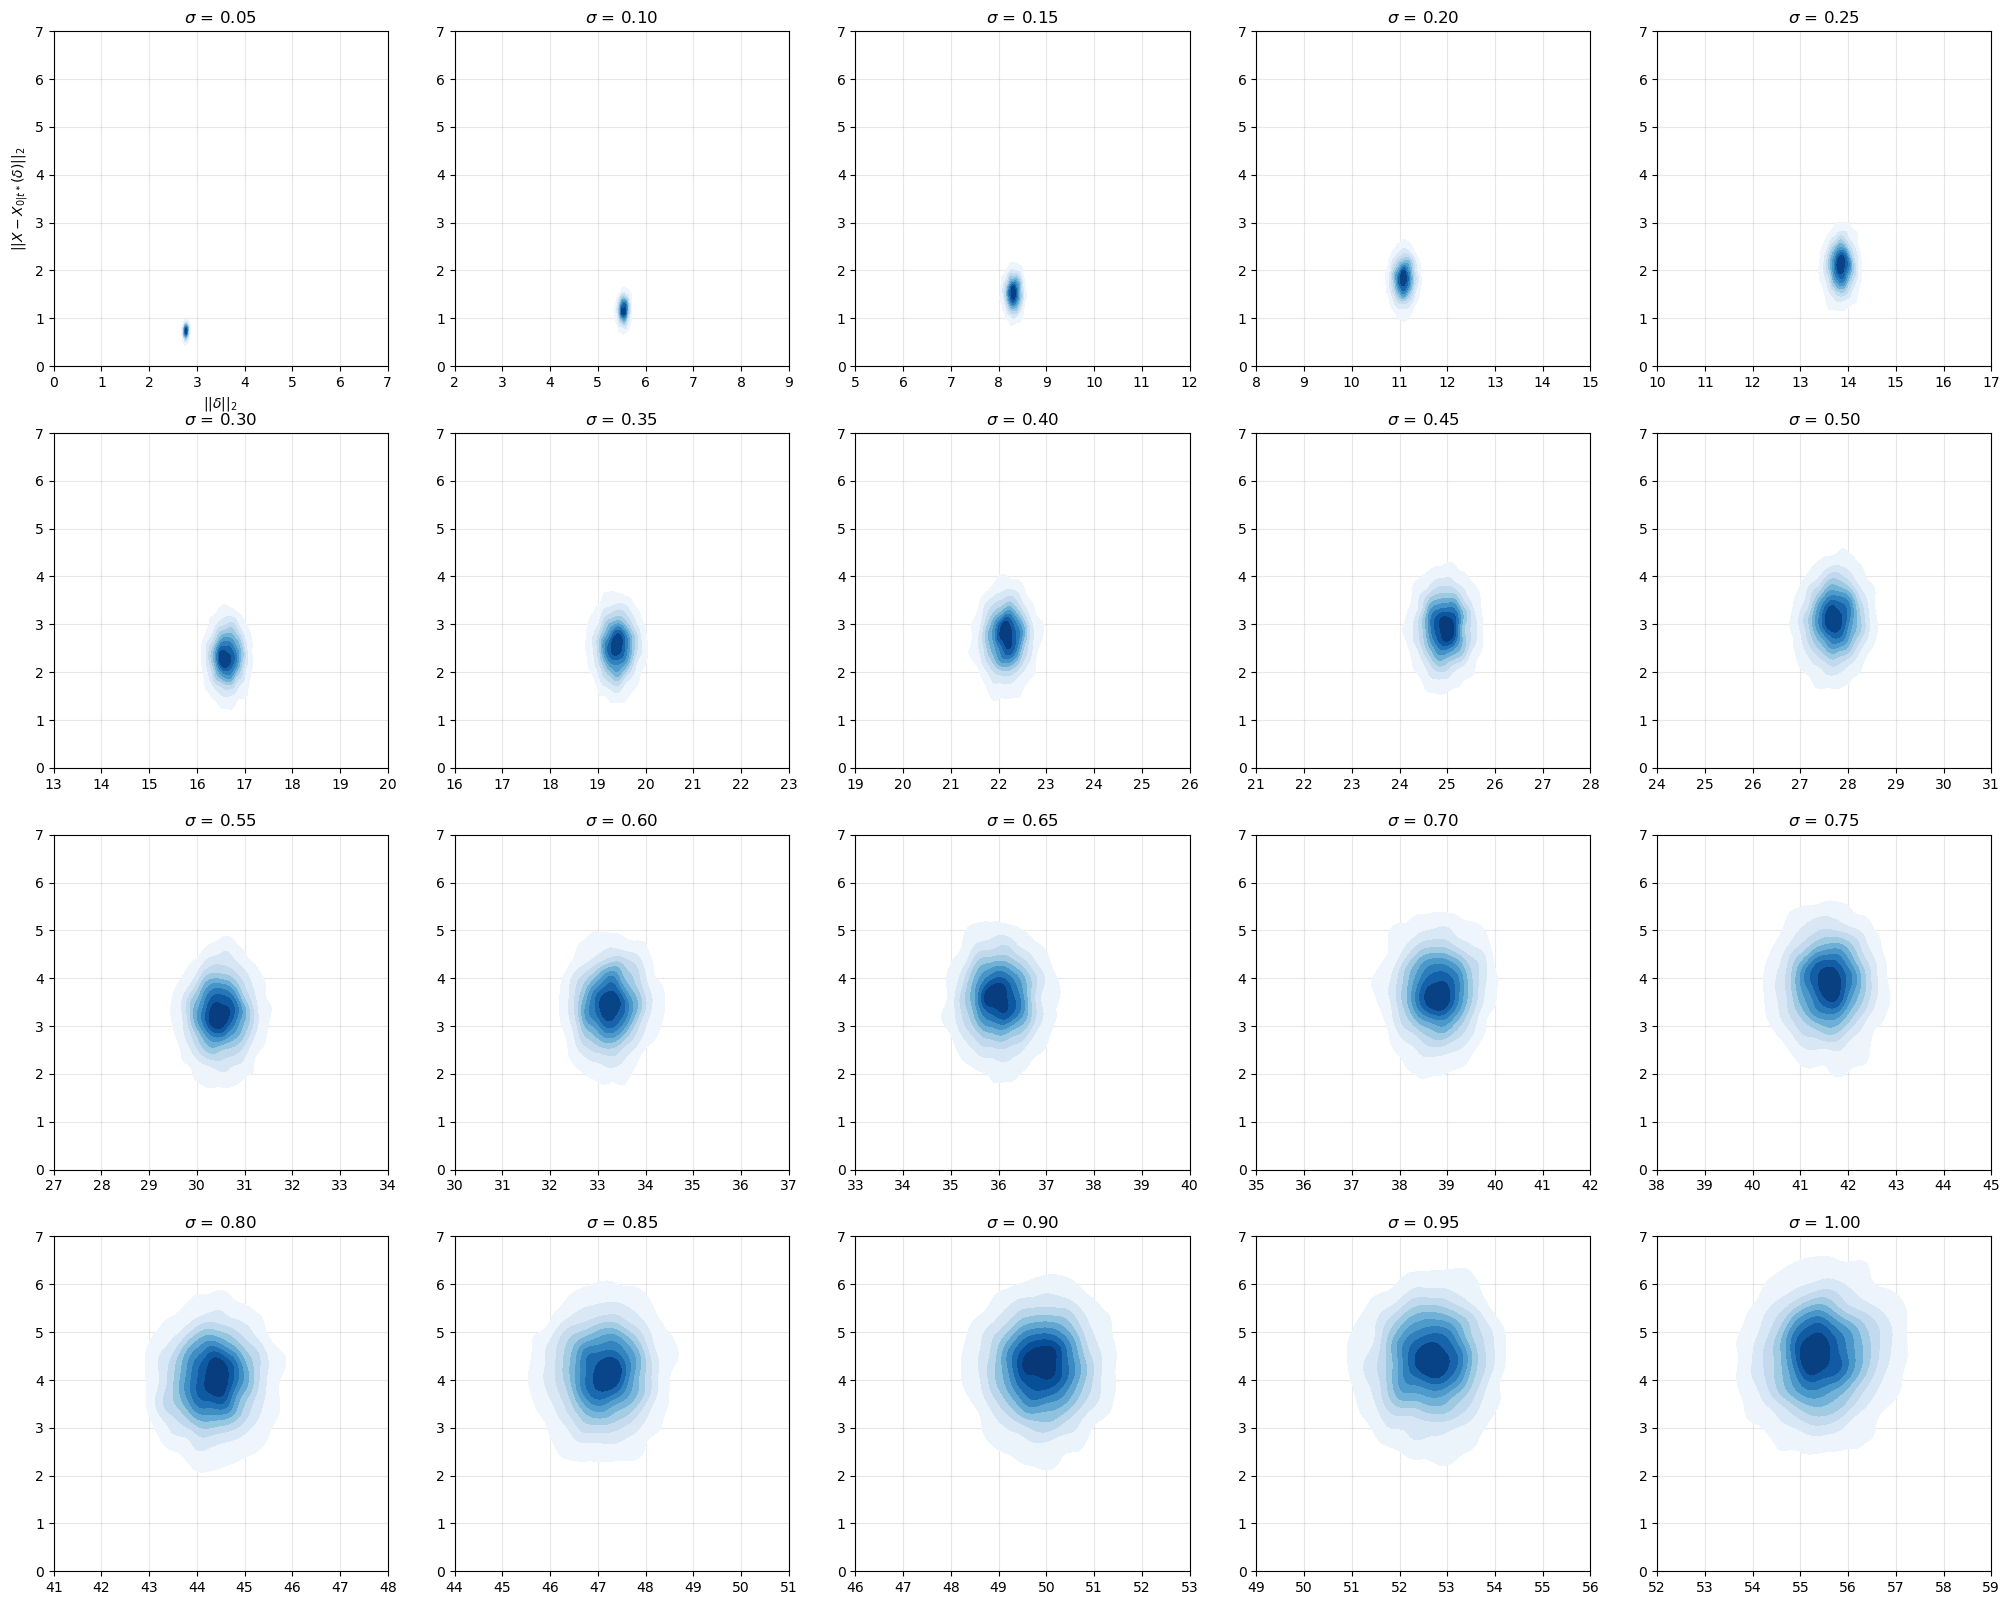

In [22]:
import seaborn as sns

num_rows = 4
num_cols = (len(sigmas) - 1) // num_rows

fig, axs = plt.subplots(num_rows, num_cols)
# fig.set_size_inches(5*num_rows, 5*num_cols)
fig.set_figwidth(5*num_cols)
fig.set_figheight(5*num_rows)

xlims = {
    0.05: [0,5],
    0.10: [3,8],
    0.15: [6,11],
    0.20: [9, 14],
    0.25: [11, 16],
    0.30: [14, 19],
    0.35: [17, 22],
    0.40: [20, 25],
    0.45: [22, 27],
    0.50: [25, 30],
    0.55: [28, 33],
    0.60: [31,36],
    0.65: [34, 39],
    0.70: [36, 41],
    0.75: [39, 44],
    0.80: [42, 47],
    0.85: [45, 50],
    0.90: [47, 52],
    0.95: [50, 55],
    1.00: [53, 58],
}

xlims_updated = {key: [xlims[key][0]-1, xlims[key][1]+1] for key in xlims.keys()}
xlims_updated[0.05] = [xlims[0.05][0], xlims[0.05][1]+2] 

var_xs = list()
var_ys = list()

ix = 0
for (sigma) in tqdm(sigmas):
    if sigma == 0:
        ix = 0
        continue
    
    ax = axs[ix // num_cols, ix % num_cols]

    # ax.scatter(l2_distances_not_denoised[sigma], l2_distances_denoised[sigma])
    
    sns.kdeplot(x=l2_distances_not_denoised[sigma], y=l2_distances_denoised[sigma], cmap="Blues", fill=True, ax=ax, zorder=5)

    ax.set_xticks(np.arange(xlims_updated[sigma][0], xlims_updated[sigma][1]+0.1, 1))
    ax.set_yticks(np.arange(0, 7.1, 1))

    ax.set_xlim([xlims_updated[sigma][0], xlims_updated[sigma][1]])
    ax.set_ylim([0, 7])

    ax.grid(zorder=0, alpha=0.3)

    var_x = torch.tensor(l2_distances_not_denoised[sigma]).var().item()
    var_y = torch.tensor(l2_distances_denoised[sigma]).var().item()

    var_xs.append(var_x)
    var_ys.append(var_y)

    # ax.set_title(r"$\sigma$ = " + "{:.2f}\nvar(X): {:.2f}\nvar(Y): {:.2f}".format(sigma, var_x, var_y))
    ax.set_title(r"$\sigma$ = " + "{:.2f}".format(sigma))

    if ix == 0:
        ax.set_xlabel(r"$||\delta||_2$")
        ax.set_ylabel(r"$||X - X_{0|t^\ast}\left(\delta\right)||_2$")

    ix += 1

# plt.savefig("./ICML_plots/cifar10_l2_distances.pdf")

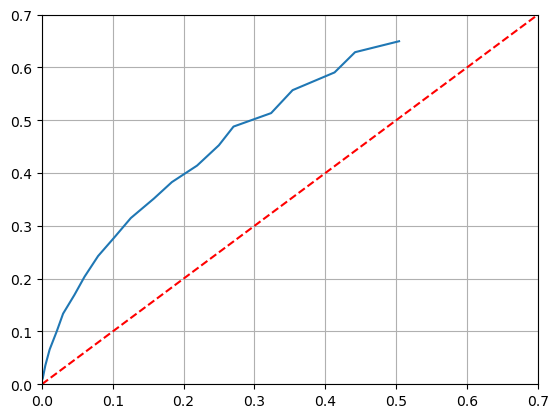

In [23]:
plt.plot(var_xs, var_ys)
plt.plot([0, 0.7], [0, 0.7], "--r")

plt.xticks(np.arange(0, 0.71, 0.1))
plt.yticks(np.arange(0, 0.71, 0.1))

plt.xlim([0, 0.7])
plt.ylim([0, 0.7])

plt.grid()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:10<00:00,  2.05it/s]


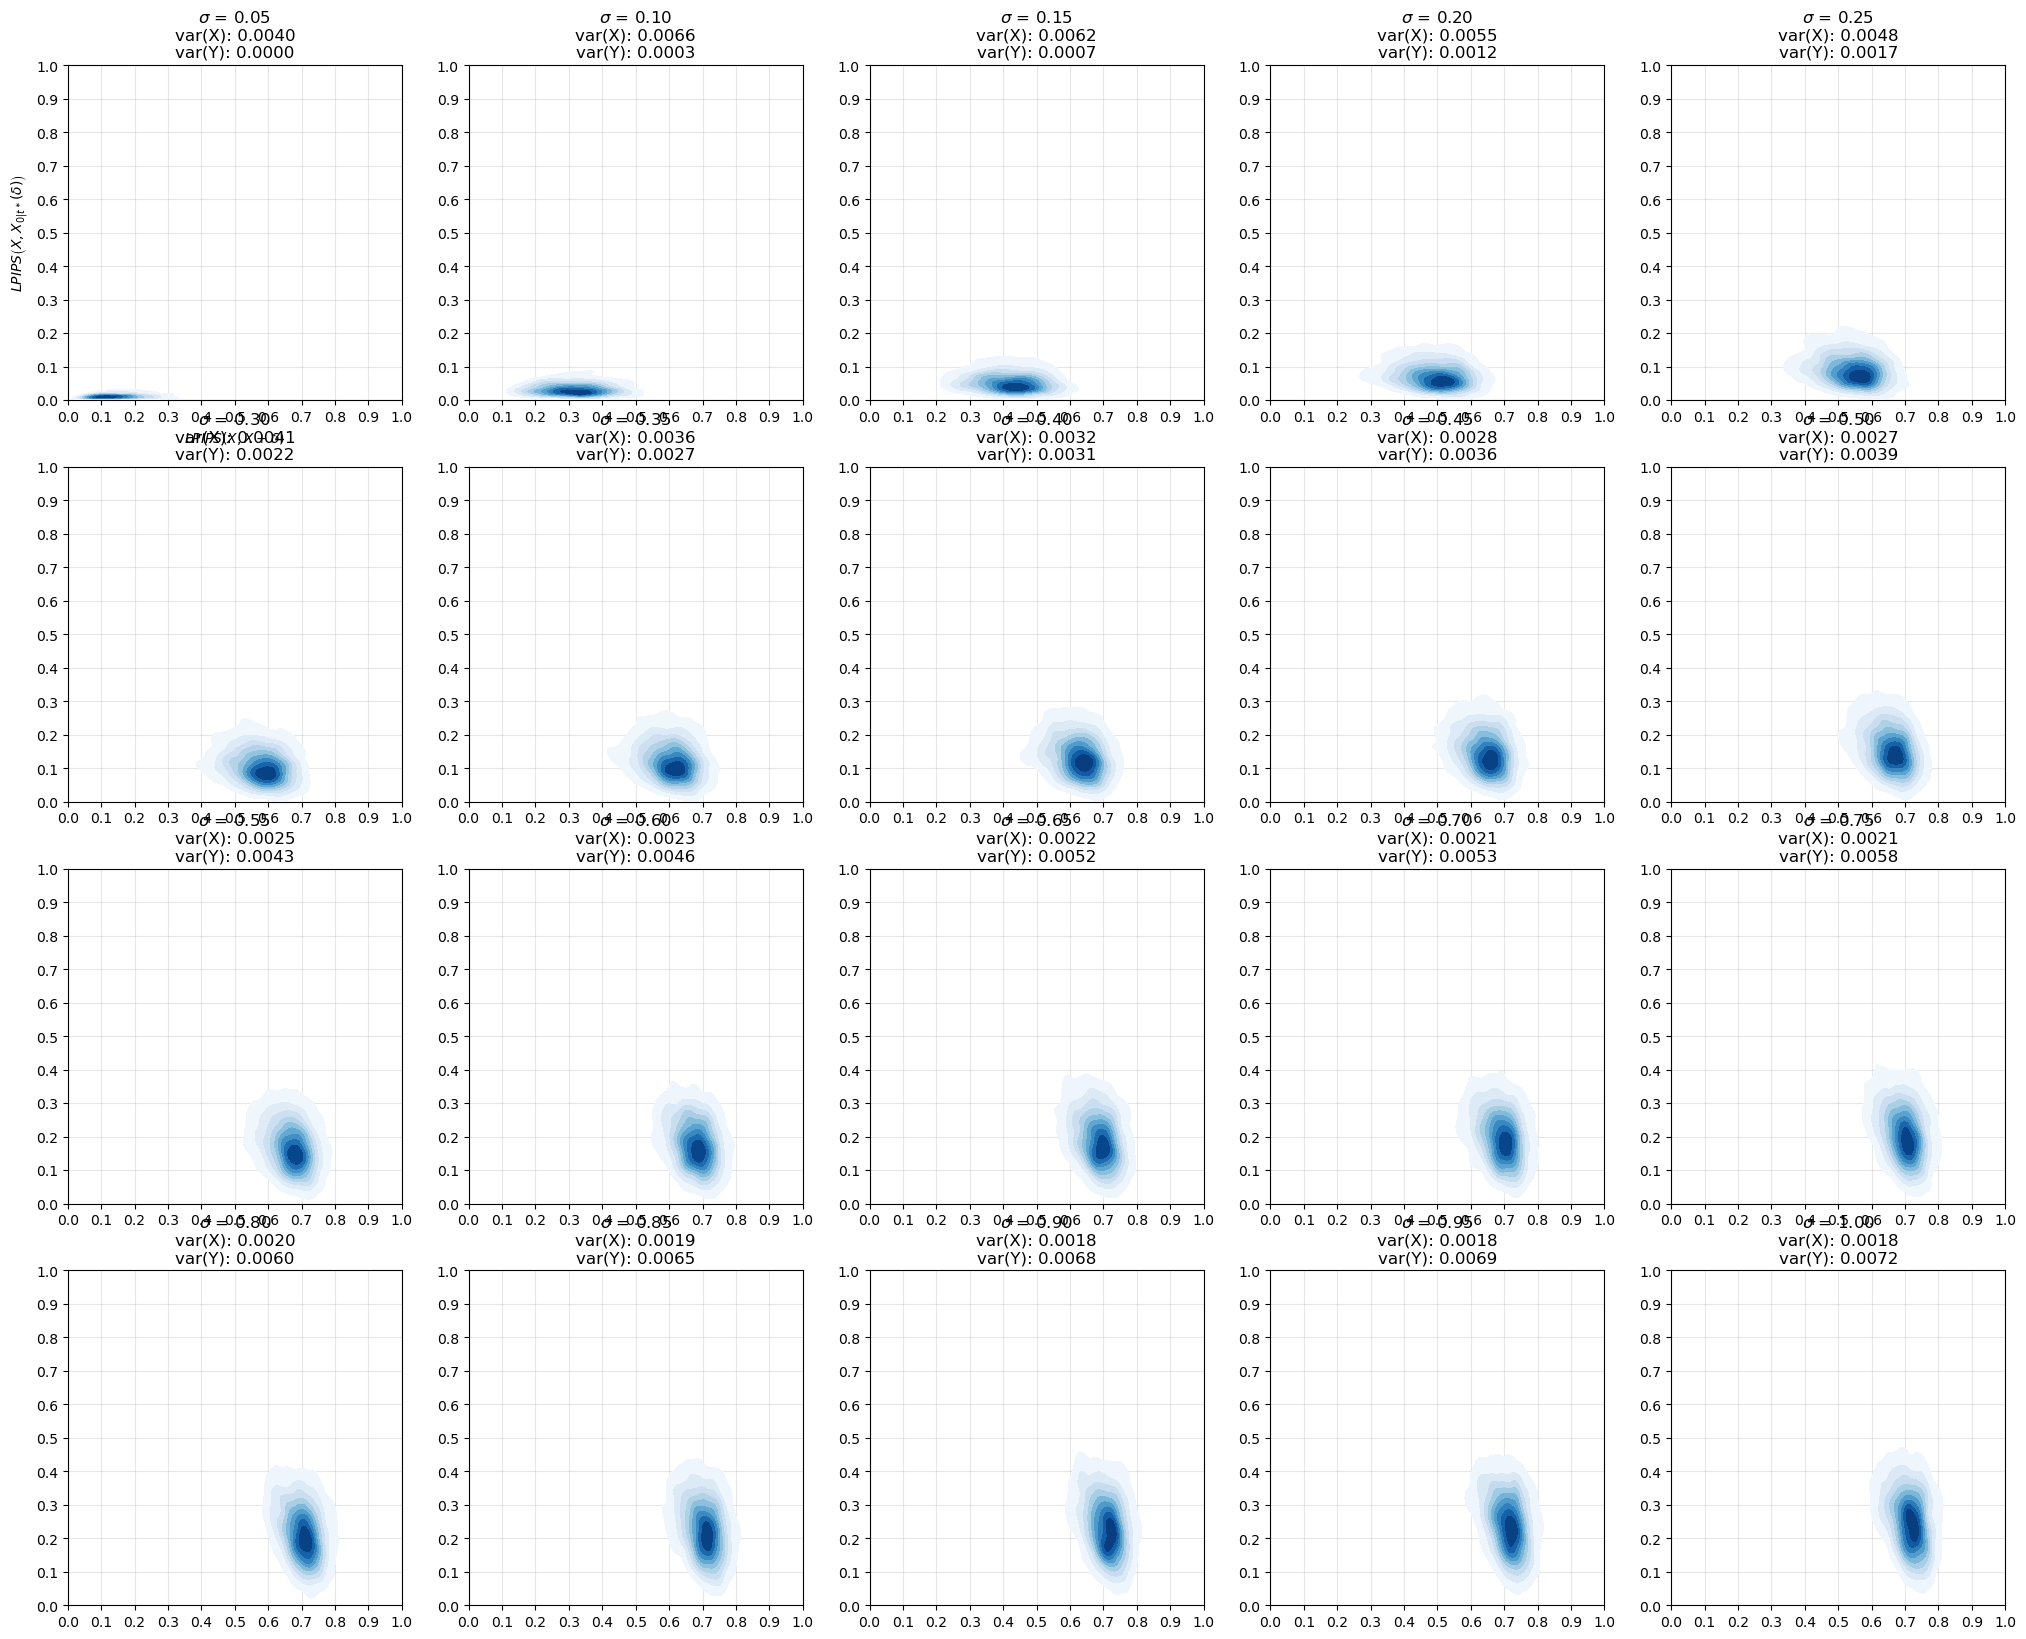

In [28]:
num_rows = 4
num_cols = (len(sigmas) - 1) // num_rows

fig, axs = plt.subplots(num_rows, num_cols)
# fig.set_size_inches(5*num_rows, 5*num_cols)
fig.set_figwidth(5*num_cols)
fig.set_figheight(5*num_rows)

var_xs = list()
var_ys = list()

ix = 0
for (sigma) in tqdm(sigmas):
    if sigma == 0:
        ix = 0
        continue
        
    ax = axs[ix // num_cols, ix % num_cols]

    # ax.scatter(lpips_distances_not_denoised[sigma], lpips_distances_denoised[sigma])
    
    sns.kdeplot(x=lpips_distances_not_denoised[sigma], y=lpips_distances_denoised[sigma], cmap="Blues", fill=True, ax=ax, zorder=5)

    # ax.set_xticks(np.arange(0.5, 0.91, 0.1))
    # ax.set_yticks(np.arange(0, 0.51, 0.1))

    # ax.set_xlim([0.5, 0.9])
    # ax.set_ylim([0, 0.5])

    
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_yticks(np.arange(0, 1.1, 0.1))

    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    
    ax.grid(zorder=0, alpha=0.3)

    var_x = torch.tensor(lpips_distances_not_denoised[sigma]).var().item()
    var_y = torch.tensor(lpips_distances_denoised[sigma]).var().item()

    var_xs.append(var_x)
    var_ys.append(var_y)

    ax.set_title(r"$\sigma$ = " + "{:.2f}\nvar(X): {:.4f}\nvar(Y): {:.4f}".format(sigma, var_x, var_y))

    # ax.set_title(r"$\sigma$ = " + "{:.2f}".format(sigma))

    if ix == 0:
        ax.set_xlabel(r"$LPIPS\left(X, X+\delta\right)$")
        ax.set_ylabel(r"$LPIPS\left(X, X_{0|t^\ast}\left(\delta\right)\right)$")

    ix += 1

# plt.savefig("./ICML_plots/cifar10_lpips_distances.pdf")

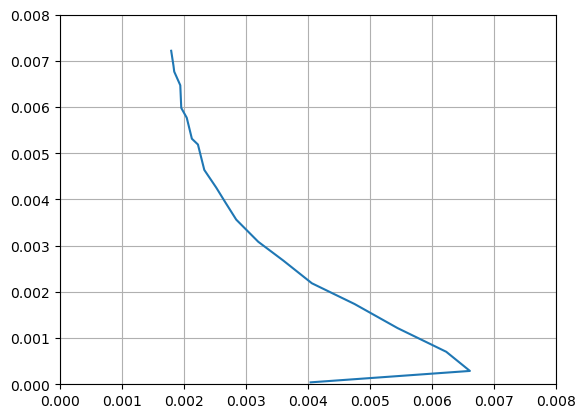

In [33]:
plt.plot(var_xs, var_ys)
# plt.plot([0, 0.7], [0, 0.7], "--r")

plt.xticks(np.arange(0, 0.0081, 0.001))
plt.yticks(np.arange(0, 0.0081, 0.001))

plt.xlim([0, 0.008])
plt.ylim([0, 0.008])

plt.grid()

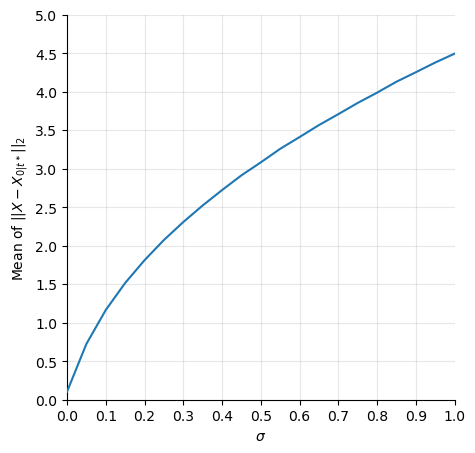

In [17]:
l2_sigmas = [] 

for sigma in sigmas:
    l2_sigmas.append(torch.tensor(l2_distances_denoised[sigma]).mean().item())

plt.figure(figsize=(5,5))

plt.plot(sigmas, l2_sigmas, zorder=5, color="#1f77b4")

plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 5.1, 0.5))

plt.xlim([0, 1])
plt.ylim([0,5])

plt.xlabel(r"$\sigma$")
plt.ylabel(r"Mean of $||X - X_{0|t^\ast}||_2$")

plt.gca().spines[["top","right"]].set_visible(False)

plt.grid(zorder=0, alpha=0.3)

plt.savefig("./ICML_plots/cifar10_mean_l2_distances.pdf")

plt.show()

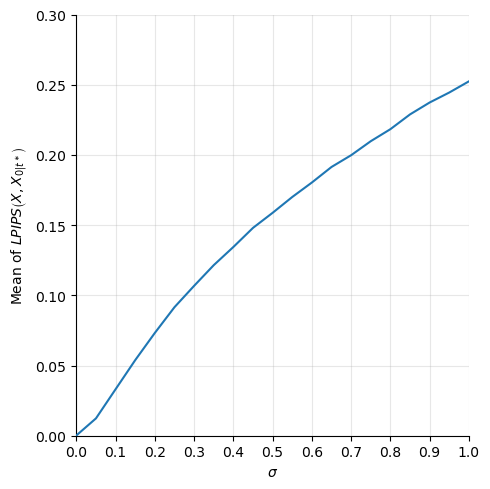

In [16]:
lpips_sigmas = [] 

for sigma in sigmas:
    lpips_sigmas.append(torch.tensor(lpips_distances_denoised[sigma]).mean().item())

plt.figure(figsize=(5,5))

plt.plot(sigmas, lpips_sigmas, zorder=5, color="#1f77b4")
# plt.plot(sigmas, lpips_sigmas, zorder=5)

plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 0.31, 0.05))

plt.xlim([0, 1])
plt.ylim([0,0.3])

plt.xlabel(r"$\sigma$")
plt.ylabel(r"Mean of $LPIPS\left(X, X_{0|t^\ast}\right)$")

plt.gca().spines[["top","right"]].set_visible(False)

plt.grid(zorder=0, alpha=0.3)

plt.tight_layout()

plt.savefig("./ICML_plots/cifar10_mean_lpips_distances.pdf")

plt.show()